In [2]:
import os
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from IPython.display import clear_output

from tqdm import tqdm_notebook,tqdm

from copy import copy,deepcopy

matplotlib.style.use('ggplot')

## read data

In [3]:
colnames_from = ['CD4SP', 'Donor(CD4SP)', 'EdU+(CD4SP)', 'CD8 SP',
       'Donor(CD8 SP)', 'EdU+(CD8 SP)', 'ISP', 'Donor(ISP)', 'EdU+(ISP)',
       'DN1', 'Donor(DN1)', 'EdU+(DN1)', 'DN2', 'Donor(DN2)', 'EdU+(DN2)',
       'DN3', 'Donor(DN3)', 'EdU+(DN3)', 'DN4', 'Donor(DN4)', 'EdU+(DN4)',
       'DP', 'Donor(DP)', 'EdU+(DP)', 'Total EdU+']
colnames_to = ['CD4SP-Total', 'CD4SP-Donor', 'CD4SP-EdU+', 'CD8SP-Total',
       'CD8SP-Donor', 'CD8SP-EdU+', 'ISP-Total', 'ISP-Donor', 'ISP-EdU+',
       'DN1-Total', 'DN1-Donor', 'DN1-EdU+', 'DN2-Total', 'DN2-Donor', 'DN2-EdU+',
       'DN3-Total', 'DN3-Donor', 'DN3-EdU+', 'DN4-Total', 'DN4-Donor', 'DN4-EdU+',
       'DP-Total', 'DP-Donor', 'DP-EdU+', 'Total_EdU+']

mapper = dict( (from_col,col_to) for from_col,col_to in zip(colnames_from,colnames_to))

In [4]:
all_files = os.listdir('csvs/')

all_dfs=[]# = pd.DataFrame()

big_grafts = ['__c_d1-5_RP934A_001,fcs','__c_d1-5_RP942B_005,fcs','__a_d0-5_RP933A_005.fcs',\
              '__a_d0-5_RP941A_003.fcs']

exhausted = ['__d_d2_RP943B_006.fcs']

for fn in all_files:
    if fn[-3:]=='csv':
#         fn_split=fn[:-4].split('_')
#         print(fn_split)
        print(fn)
        df = pd.read_csv('csvs/'+fn).rename(columns=mapper)
        timepoint = df.columns[0][3:]
        df['timepoint'] = timepoint
        df = df.rename(columns={df.columns[0]:'fn'})
        cols_to_drop=[]
        for col in df.columns.tolist():
            if ('Unnamed' in col):
                cols_to_drop.append(col)
        df.drop(columns=cols_to_drop,inplace=True)
        # drop big grafts
#         df['to_drop'] = df['fn'].apply(lambda fn: 1 if fn in big_grafts else 0)
        if 'to_drop' in df.columns:
            all_dfs.append(df[df['to_drop']==0].dropna())
        else:
            all_dfs.append(df.dropna())
            
data = pd.concat(all_dfs).sort_values(by='timepoint')
data['to_drop'] = data['fn'].apply(lambda f: 1 if ('ctrl' in f) or ('Ctrl' in f) else 0 )

data = data[data['to_drop']==0]
data['timepoint'] = pd.to_numeric(data['timepoint'])

data['Total_Donor'] = data.apply(lambda r: np.sum([ r[lab] for lab in data.columns if 'Donor' in lab ] ) ,axis=1)
data['Total_Donor2'] = data.apply(lambda r: np.sum([ r[lab+'-Donor'] for lab in ['DN3','DN4','ISP','DP'] ] ) ,axis=1)
data['Total_EdU+'] = data.apply(lambda r: np.sum([ r[lab] for lab in data.columns if ('-EdU+' in lab)and(lab!='Total_EdU+') ] ) ,axis=1)
data['Total_EdU2'] = data.apply(lambda r: np.sum([ r[lab+'-EdU+'] for lab in ['DN3','DN4','ISP','DP'] ] ) ,axis=1)

20171130_Transplant_20171030_EdU_Chase_Day_3.csv
20200225_Transplant_20190805_EdU_chase_D1.csv
20190808_Transplant_20190708_EdU_chase_d3.csv
20190816_Transplant_20190718_EdU_chase_d1_5.csv
20190903_Transplant_20190805_EdU_chase_D1_5.csv
20190815_Transplant_20190718_EdU_chase_d0_5.csv
20171128_Transplant_20171030_EdU_Chase_Day_1.csv
20190817_Transplant_20190718_EdU_chase_d4.csv
20171129_Transplant_20171030_EdU_Chase_Day_2.csv
20171201_Transplant_20171030_EdU_Chase_Day_4.csv
20190813_Transplant_20190708_EdU_chase_d8.csv
20190902_Transplant_20190805_EdU_chase_D0_5.csv
20190817_Transplant_20190718_EdU_chase_d2.csv


In [5]:
data.head()

,fn,CD4SP-Total,CD4SP-Donor,CD4SP-EdU+,CD8SP-Total,CD8SP-Donor,CD8SP-EdU+,ISP-Total,ISP-Donor,ISP-EdU+,...,DN4-EdU+,DP-Total,DP-Donor,DP-EdU+,Total_EdU+,timepoint,to_drop,Total_Donor,Total_Donor2,Total_EdU2
3,"t_a_d0_5_RP966A_004,fcs",262824.0,259670.0,32459.0,222193.0,221749.0,77390.0,3356.0,3319.0,2881.0,...,65.0,540312.0,539231.0,99758.0,212893.0,0.5,0,1024812.0,542972.0,103008.0
0,__a_d0-5_RP933A_005.fcs,539494.0,537875.0,75840.0,126490.0,125985.0,31622.0,112547.0,112434.0,107599.0,...,136909.0,15172217.0,15172217.0,3641332.0,4043657.0,0.5,0,16221565.0,15548846.0,3930474.0
1,__a_d0-5_RP933B_006.fcs,97000.0,96612.0,10724.0,56409.0,56239.0,18615.0,462.0,454.0,375.0,...,6.0,210296.0,209665.0,22225.0,51988.0,0.5,0,363150.0,210241.0,22639.0
2,__a_d0-5_RP936A_007.fcs,555704.0,554593.0,54239.0,195778.0,195386.0,50605.0,4404.0,4382.0,2691.0,...,115.0,2822683.0,2819860.0,327104.0,435085.0,0.5,0,3576000.0,2825455.0,330166.0
7,__a_d0-5_RP941B_004.fcs,416719.0,414219.0,35623.0,247279.0,246043.0,61511.0,821.0,812.0,553.0,...,9.0,329596.0,327619.0,23752.0,121578.0,0.5,0,989524.0,328739.0,24414.0


In [6]:
variabs = ['DN3','DN4','ISP','DP']

data['Total_Donor2'] = data.apply(lambda r: np.sum([ r[lab+'-Donor'] for lab in variabs ] ) ,axis=1)

dfs = []
for i,var in enumerate(variabs):
#    data[var.lower()] = (data[var+'-EdU+']/data[var+'-Total'])*(data[var+'-Donor']/data[var+'-Total']) # assuming independence

#     data[var.lower()] = (data[var+'-EdU+']/data['Total_Donor2'])
    data[var.lower()] = (data[var+'-EdU+']/data[var+'-Donor'])
    data[var+'_frac'] = data[var.lower()]
    df = data[['timepoint',var.lower()]].copy()
    df['t'] = df['timepoint']+i*10
    df.rename(columns={var.lower():'y'},inplace=True)
    dfs.append(df[['t','y']])

dfs = pd.concat(dfs).dropna()



In [7]:
variabs = ['DN3','DN4','ISP','DP']

data['Total_Donor2'] = data.apply(lambda r: np.sum([ r[lab+'-Donor'] for lab in variabs ] ) ,axis=1)

dfs_T = []
for i,var in enumerate(variabs):
    data[var.lower()+'_T'] = (data[var+'-Donor'])/data['Total_Donor2']
    df = data[['timepoint',var.lower()+'_T']].copy()
    df['t'] = df['timepoint']+i*10
    df.rename(columns={var.lower()+'_T':'y'},inplace=True)
    dfs_T.append(df[['t','y']])

dfs_T = pd.concat(dfs_T).dropna()

/opt/conda/envs/main/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


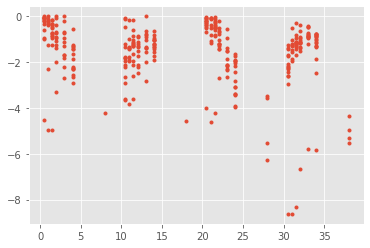

In [8]:
plt.plot(dfs['t'],np.log(dfs['y']),ls='',marker='.')

In [10]:
Ns = []
for i in [10,20,30,40]:
    mean = dfs_T.query("(t>(@i-10))&(t<@i)")['y'].mean()
    Ns.append(mean)
    
Ns

[0.0026242479778069414,
 0.0013174325062722384,
 0.012226055086937528,
 0.9838322644289832]

## define functions

In [11]:
def calc_r2(func,xdata,ydata,params):
    residuals = ydata - func(xdata,*params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.sum(ydata))**2)
    r_sq = 1-(ss_res/ss_tot)
    return r_sq

def calc_residuals(func,xdata,ydata,params):
    residuals = ydata - func(xdata,*params)
    ss_res = np.sum(residuals**2)
    return ss_res

def calc_eff(params,idx,p_range):
    res0 = calc_residuals(func3,dfs['t'],dfs['y'] , params)
    set_list = []
    new_params = copy(params)
    for p in p_range:
        new_params[idx] = p   
        res = calc_residuals(func3,dfs['t'],dfs['y'] , new_params)
        set_list.append(res/res0)
    return np.array(set_list)

In [13]:
def f_full(y,t,params):
    alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp = params
    dn3,dn4,isp,dp,dn3u,dn4u,ispu,dpu = y

    dydt = [(1-alpha)*r3*dn3 -k3*dn3 -d3*dn3,\
            (1-alpha)*r4*dn4 + k3*dn3 - k4*dn4 - d4*dn4,\
            (1-alpha)*risp*isp + k4*dn4 - kisp*isp - disp*isp,\
            (1-alpha)*rdp*dp + kisp*isp -ddp*dp,\
            r3*dn3u + alpha*r3*dn3 - k3*dn3u-d3*dn3u,\
            r4*dn4u + alpha*r4*dn4 + k3*dn3u - k4*dn4u - d4*dn4u,\
            risp*ispu + alpha*risp*isp + k4*dn4u - kisp*ispu - disp*ispu,\
            rdp*dpu + alpha*rdp*dp + kisp*ispu -ddp*dpu\
           ]
    return dydt

def full_model(t,alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp,dn30,dn40,isp0,dp0):
    """
    function for curve_fit
    solves ODEs and puts the output in a single line (so that we are optimizing a single function)
    """
    params = alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp
    y0 = [Ns[0]*dn30,Ns[1]*dn40,Ns[2]*isp0,Ns[3]*dp0,Ns[0]*(1-dn30),Ns[1]*(1-dn40),Ns[2]*(1-isp0),Ns[3]*(1-dp0)]
    
    # variabs = ['DN3','DN4','ISP','DP']
    # solve and interpolate with these params
    
    tt=np.arange(0,10,.1)
    psoln = odeint(f_full, y0, tt, args=(params,))
    sol = [interp1d(tt,psoln[:,i]) for i in range(8) ]
    # get the values for t (** the original values **)
    sol_idx = [ divmod(t1,10) for t1 in t[t<40] ]

#     values = [ sol[int(idx[0])](idx[1]) for idx in sol_idx]

    values = [ sol[int(idx[0])](idx[1])/(sol[int(idx[0])](idx[1])+sol[int(idx[0])+4](idx[1]))  for idx in sol_idx ]
#     print(values)
    return np.array(values)

def full_model_nok4(t,alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp,dn30,dn40,isp0,dp0):
    """
    function for curve_fit
    solves ODEs and puts the output in a single line (so that we are optimizing a single function)
    """
    params = alpha,k3,0,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp
    y0 = [Ns[0]*dn30,Ns[1]*dn40,Ns[2]*isp0,Ns[3]*dp0,Ns[0]*(1-dn30),Ns[1]*(1-dn40),Ns[2]*(1-isp0),Ns[3]*(1-dp0)]
    
    # variabs = ['DN3','DN4','ISP','DP']
    # solve and interpolate with these params
    
    tt=np.arange(0,10,.1)
    psoln = odeint(f_full, y0, tt, args=(params,))
    sol = [interp1d(tt,psoln[:,i]) for i in range(8) ]
    # get the values for t (** the original values **)
    sol_idx = [ divmod(t1,10) for t1 in t[t<40] ]

#     values = [ sol[int(idx[0])](idx[1]) for idx in sol_idx]

    values = [ sol[int(idx[0])](idx[1])/(sol[int(idx[0])](idx[1])+sol[int(idx[0])+4](idx[1]))  for idx in sol_idx ]
#     print(values)
    return np.array(values)

In [14]:
init_alpha=[0]
init_k = [.01,1,.02]
init_d = [.012,.0015,.014,.01]
init_r=[.2,.1,.01,.1]
init_0=[1,0.1,1,0.1]

bounds_a = [[0,1]]
bounds_k = [ [0,np.inf],[0,np.inf],[0,np.inf]]
bounds_d = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_r = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_0 = [ [0,1],[0,1],[0,1],[0,1] ]

full_params,cov = curve_fit(full_model,dfs['t'],dfs['y'],\
                            p0=init_alpha+init_k+init_d+init_r+init_0,\
                            bounds=np.array(bounds_a+bounds_k+bounds_d+bounds_r+bounds_0).T,\
                            maxfev = 5000 )

calc_residuals(full_model,dfs['t'],dfs['y'],full_params)

14.311839894458815

In [15]:
full_params

array([1.38625158e-01, 1.20087561e-04, 9.25952726e-40, 5.12656702e+00,
       1.10853323e+00, 2.12057521e+00, 2.62332934e-02, 3.84735048e+00,
       2.32806335e+00, 7.11047883e-02, 2.91832369e+00, 5.50639648e-03,
       8.58153156e-01, 2.70179211e-01, 9.35587401e-01, 1.45796365e-01])

## Sample params

In [30]:
sampled_params = []

In [31]:
bounds_a = [[0,1]]
bounds_k = [ [0,np.inf],[0,np.inf],[0,np.inf]]
bounds_d = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_r = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_0 = [ [0,1],[0,1],[0,1],[0,1] ]

In [ ]:
for n in tqdm(range(1000)):
    init_alpha=np.random.uniform(0,1,1).tolist()
    init_k = np.random.uniform(0,10,3).tolist()
    init_d = np.random.uniform(0,10,4).tolist()
    init_r= np.random.uniform(0,10,4).tolist()
    init_0=[1,0.,1,0]

    init_guess=init_alpha+init_k+init_d+init_r+init_0
    
    try:
        samp_params,cov = curve_fit(full_model,dfs['t'],dfs['y'],p0=init_guess,\
                               bounds=np.array(bounds_a+bounds_k+bounds_d+bounds_r+bounds_0).T,\
                               maxfev = 5000 )
        res = calc_residuals(full_model,dfs['t'],dfs['y'] , samp_params)
        sampled_params.append(samp_params.tolist()+[res])
    except Exception as e:
        print(e)
        continue

  4%|▍         | 41/1000 [06:05<1:02:01,  3.88s/it]

array must not contain infs or NaNs


  5%|▍         | 48/1000 [06:33<1:23:46,  5.28s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
  5%|▍         | 49/1000 [06:33<1:00:18,  3.80s/it]

array must not contain infs or NaNs


  7%|▋         | 71/1000 [17:39<2:59:29, 11.59s/it] /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
  7%|▋         | 72/1000 [17:39<2:07:06,  8.22s/it]

array must not contain infs or NaNs


  9%|▉         | 89/1000 [1:08:45<131:03:40, 517.91s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 13%|█▎        | 131/1000 [1:27:28<3:51:19, 15.97s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 14%|█▎        | 136/1000 [1:53:40<108:16:08, 451.12s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 14%|█▍        | 139/1000 [1:53:56<37:59:34, 158.86s/it] /opt/conda/envs/main/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 15%|█▍        | 146/1000 [1:54:34<3:57:57, 16.72s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 19%

array must not contain infs or NaNs


 36%|███▌      | 355/1000 [3:08:04<58:09,  5.41s/it]    /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
 36%|███▌      | 356/1000 [3:08:05<41:56,  3.91s/it]

array must not contain infs or NaNs


 36%|███▌      | 358/1000 [3:08:14<48:07,  4.50s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 36%|███▋      | 365/1000 [3:13:28<3:42:41, 21.04s/it] /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encoun

Residuals are not finite in the initial point.


 41%|████      | 409/1000 [4:00:24<97:28:19, 593.74s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 42%|████▏     | 418/1000 [4:01:29<5:07:08, 31.66s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 42%|████▏     | 419/1000 [4:01:29<3:35:44, 22.28s/it]

array must not contain infs or NaNs


 42%|████▏     | 423/1000 [4:26:36<73:14:10, 456.93s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 49%|████▉     | 492/1000 [4:53:01<41:56,  4.95s/it]    /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
 52%|█████▏    | 521/1000 [4:59:24<37:59,  4.76s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] ==

array must not contain infs or NaNs


 57%|█████▋    | 566/1000 [5:54:32<66:02:30, 547.81s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 59%|█████▉    | 590/1000 [5:58:29<44:57,  6.58s/it]  

array must not contain infs or NaNs


 61%|██████    | 609/1000 [5:59:50<38:22,  5.89s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
 61%|██████    | 610/1000 [5:59:51<27:37,  4.25s/it]

array must not contain infs or NaNs


 66%|██████▋   | 664/1000 [6:07:39<52:00,  9.29s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 66%|██████▋   | 665/1000 [6:07:39<37:02,  6.63s/it]

array must not contain infs or NaNs


 68%|██████▊   | 677/1000 [6:37:02<45:43:59, 509.72s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 68%|██████▊   | 680/1000 [7:11:31<63:04:44, 709.64s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 72%|███████▏  | 723/1000 [7:48:52<44:47:54, 582.22s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 79%|███████▉  | 794/1000 [8:17:59<21:34,  6.28s/it]    

In [2]:
plt.hist(np.array(sampled_params_nok4)[:,-1],bins=np.arange(0,30,1));

NameError: name 'plt' is not defined

In [16]:
import joblib

In [55]:
joblib.dump(sampled_params,'Transplant_Params2.joblib')

['Transplant_Params2.joblib']

## Plot Data

In [20]:
samp_params = joblib.load('Transplant_Params2.joblib')

In [21]:
params_df = pd.DataFrame(samp_params)
col_mapper = dict(zip([i for i in range(21)],['alpha','k3','k4','kisp','d3','d4','disp','ddp','r3','r4','risp','rdp','dn30','dn40','isp0','dp0','ssr']))
params_df.rename(columns=col_mapper,inplace=True)

In [22]:
params_df

,alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp,dn30,dn40,isp0,dp0,ssr
0,0.078629,9.694369,5.643840,11.018546,8.664238,0.105317,4.101878,6.546204,6.296712,1.770509,1.658278,1.891798,0.977547,1.034469e-03,0.996227,8.998139e-03,2.804865e+01
1,0.733267,4.342808,7.039210,0.546703,8.157593,3.583903,3.730737,5.398492,1.535187,3.333258,7.145847,1.499412,0.999616,1.365893e-07,1.000000,3.331653e-07,2.906544e+06
2,0.201691,5.988517,12.199068,97.497808,4.412105,3.202803,71.800972,24.648687,1.126825,4.354456,6.742786,9.814020,0.854497,3.177065e-02,0.999741,5.499950e-01,2.891436e+01
3,0.035523,3.687851,2.329145,7.823332,8.278852,8.105905,2.705214,7.432986,8.181059,7.757118,6.567279,2.493749,0.735877,1.611021e-05,0.986964,8.433981e-02,1.662702e+01
4,0.426458,13.539234,9.182542,1.393673,3.251549,1.229588,9.252994,1.383873,8.297807,4.582512,6.136261,1.022340,0.999977,9.694298e-05,0.999973,7.685070e-04,6.450454e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,0.497871,5.686002,9.729152,3.755744,10.040433,3.822552,7.781531,4.596438,10.310516,3.991787,7.119011,3.401490,1.000000,1.000010e-10,1.000000,1.000007e-10,4.680100e+12
3898,0.024763,0.000630,1.203392,13.461882,12.905390,3.325747,2.753135,0.010866,12.874747,1.834195,17.200009,0.000071,0.853429,2.786124e-01,0.974667,8.659594e-02,1.422696e+01
3899,0.602361,6.928283,1.731018,2.769383,5.053762,2.017535,3.290012,7.853596,0.877050,4.582877,0.004197,2.154407,0.999945,7.926384e-04,0.999855,1.010612e-03,4.585383e+02
3900,0.057305,3.599940,4.197970,5.889539,4.077106,5.917133,8.487372,32.285225,5.067346,4.351076,3.120661,8.225092,0.657670,1.330765e-02,0.570076,1.103680e-01,2.090151e+01


params_df.to_csv('Transplant_params2.csv')

In [23]:
best_params = params_df[(params_df['ssr']<params_df['ssr'].quantile(.1))]

params_df.to_csv('best_Transplant_params2.csv')

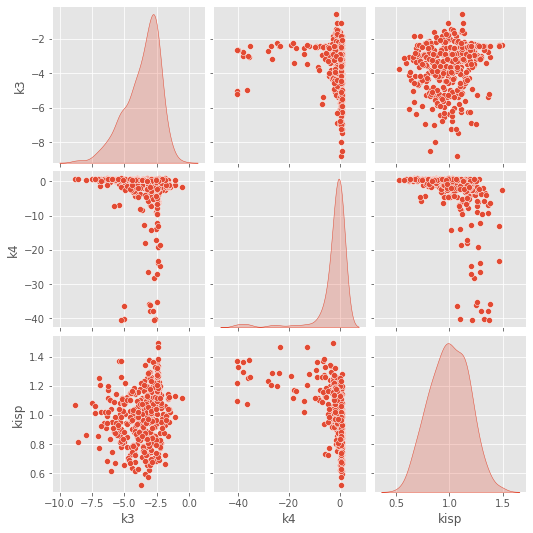

In [60]:
sns.pairplot(best_params.apply(np.log10),vars=['k3','k4','kisp'],diag_kind='kde')

In [61]:
g = sns.PairGrid(best_params[['k2','k3','k4']].apply(np.log10),vars=['k2','k3','k4'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);


KeyError: "['k2'] not in index"

In [143]:
KO_params = pd.read_csv('new_full_model_log2.csv',index_col=0).append(pd.read_csv('new_full_model_log.csv',index_col=0))
KO_params = pd.read_csv('new_full_model.csv',index_col=0)
col_mapper = dict(zip([str(i) for i in range(17)],['alpha','k3','k4','kisp','d3','d4','disp','ddp','r3','r4','risp','rdp','dn30','dn40','isp0','dp0','ssr']))
KO_params.rename(columns=col_mapper,inplace=True)

print((KO_params['ssr']<KO_params['ssr'].quantile(.1)).sum())

KO_params = KO_params[(KO_params['ssr']<KO_params['ssr'].quantile(.1))]

101


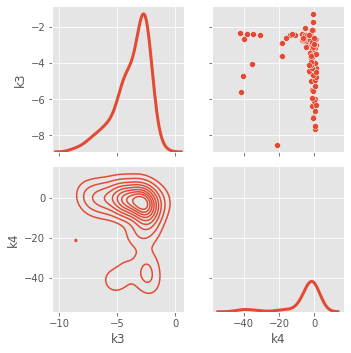

In [144]:
g = sns.PairGrid(KO_params[['k3','k4']].apply(np.log10),vars=['k3','k4'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

<AxesSubplot:>

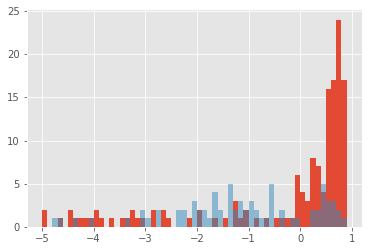

In [150]:
best_params['k4'].apply(np.log10).hist(bins=np.arange(-5,1,.1))
KO_params['k4'].apply(np.log10).hist(bins=np.arange(-5,1,.1),alpha=.5)

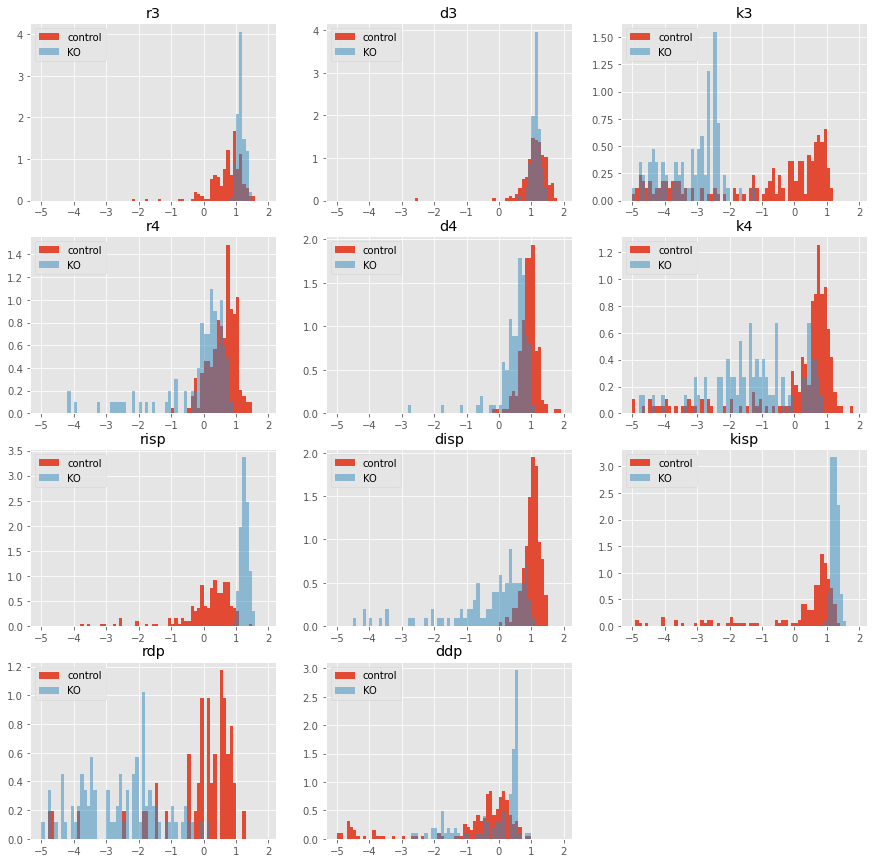

In [170]:
plt.subplots(figsize=(15,15))
for row,pop in enumerate(['3','4','isp','dp']):
    for col,param in enumerate(['r','d','k']):
        if param+pop=='kdp': continue
        plt.subplot(4,3,col + 3*row+1)
        best_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,label='control')
        KO_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,alpha=.5,label='KO')
        plt.title(param+pop)
        plt.legend(loc='upper left')

<AxesSubplot:>

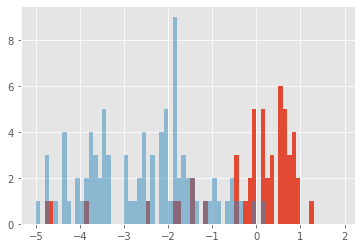

In [158]:
best_params['rdp'].apply(np.log10).hist(bins=np.arange(-5,2,.1))
KO_params['rdp'].apply(np.log10).hist(bins=np.arange(-5,2,.1),alpha=.5)

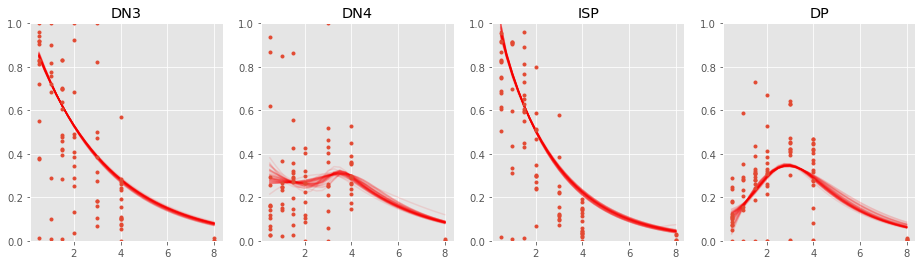

In [22]:
# params = alpha,k2,k3,k4,kisp,d2,d3,d4,disp,ddp,r2,r3,r4,risp,rdp
# y0 = [Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)]

variabs = ['DN3','DN4','ISP','DP']


fig,ax = plt.subplots(figsize=(20,4))
for k,var in enumerate(variabs):
    plt.subplot(1,5,k+1)
    for j in range(50):
        par = best_params.iloc[j].tolist()
        params = par[:12]
        dn30,dn40,isp0,dp0 = par[-5:-1]
#         y0 = 1000*np.array([Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)])
        y0 = 1000000*np.array([Ns[0]*dn30,Ns[1]*dn40,Ns[2]*isp0,Ns[3]*dp0,Ns[0]*(1-dn30),Ns[1]*(1-dn40),Ns[2]*(1-isp0),Ns[3]*(1-dp0)])

        tt=data['timepoint'].unique()
        tt = np.arange(.5,8.1,.25)
        psoln = odeint(f_full,y0,tt,args=(params,))
        plt.plot(tt,psoln[:,k]/(psoln[:,k]+psoln[:,k+4]),alpha=.1,c='r')
        plt.ylim(0,1)
        
    plt.plot(data['timepoint'],data[var+'_frac'],ls='',marker='.')
    plt.title(var)
    
plt.savefig('Transplant-timeseries.pdf')

In [31]:
residuals = []
for j in range(len(best_params)):
    par = best_params.iloc[j].tolist()
    params = par[:-1]
    # no k4
    params[2]=0
    res = calc_residuals(full_model,dfs['t'],dfs['y'] , params)
    residuals.append([par[-1],res])


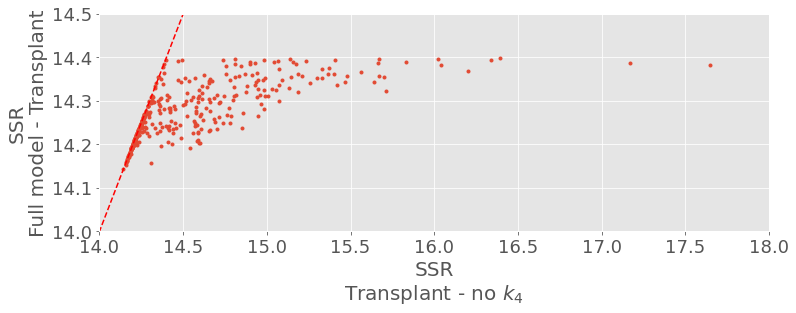

In [55]:
fig,ax = plt.subplots(figsize=(12,4))
plt.plot(np.array(residuals).T[1],np.array(residuals).T[0],marker='.',ls='')
plt.plot([0,20],[0,20],ls='--',c='r')
plt.xlim(14,18)
plt.ylim(14,14.5)
plt.xlabel('SSR\nTransplant - no $k_4$',fontdict={'size':20})
plt.ylabel('SSR\nFull model - Transplant',fontdict={'size':20})
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('SSR_Transplant_nok4.pdf')